# Machine Unlearning via Information Regularization: MNIST

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import random
from copy import deepcopy

## Load MNIST

In [2]:
# Check for MPS availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Create the data set to unlearn and the remaining data set

In [3]:
# Select 10 data points with label = 1 to unlearn
label_1_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 3]
selected_unlearn_indices = random.sample(label_1_indices, int(len(label_1_indices)*0.75))
remaining_indices = [i for i in range(len(train_dataset)) if i not in selected_unlearn_indices]

# Create datasets for unlearning and remaining data
unlearn_dataset = Subset(train_dataset, selected_unlearn_indices)
remaining_dataset = Subset(train_dataset, remaining_indices)

# Create data loaders
train_unlearn_loader = DataLoader(unlearn_dataset, batch_size=16, shuffle=True)
train_remain_loader = DataLoader(remaining_dataset, batch_size=64, shuffle=True)

## Original: None-regularizaed

In [4]:
# Define classifier
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training setup
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation setup
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')
    return correct / total


In [ ]:
evaluate_model(model_retrain, train_remain_loader)
evaluate_model(model_retrain, train_unlearn_loader)
evaluate_model(model_retrain, test_loader)

## Re-Training from Scratch

In [ ]:
# Initialize and train model
model_retrain = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_retrain.parameters(), lr=0.001)

train_model(model_retrain, train_remain_loader, criterion, optimizer, epochs=100)


Epoch 1/100, Loss: 0.2671
Epoch 2/100, Loss: 0.1081
Epoch 3/100, Loss: 0.0767
Epoch 4/100, Loss: 0.0589
Epoch 5/100, Loss: 0.0454
Epoch 6/100, Loss: 0.0384
Epoch 7/100, Loss: 0.0306
Epoch 8/100, Loss: 0.0265
Epoch 9/100, Loss: 0.0240
Epoch 10/100, Loss: 0.0216
Epoch 11/100, Loss: 0.0183
Epoch 12/100, Loss: 0.0188
Epoch 13/100, Loss: 0.0158
Epoch 14/100, Loss: 0.0162
Epoch 15/100, Loss: 0.0145
Epoch 16/100, Loss: 0.0136
Epoch 17/100, Loss: 0.0133
Epoch 18/100, Loss: 0.0128
Epoch 19/100, Loss: 0.0128
Epoch 20/100, Loss: 0.0128
Epoch 21/100, Loss: 0.0118
Epoch 22/100, Loss: 0.0081
Epoch 23/100, Loss: 0.0125
Epoch 24/100, Loss: 0.0071
Epoch 25/100, Loss: 0.0092
Epoch 26/100, Loss: 0.0148
Epoch 27/100, Loss: 0.0070
Epoch 28/100, Loss: 0.0094
Epoch 29/100, Loss: 0.0094
Epoch 30/100, Loss: 0.0089
Epoch 31/100, Loss: 0.0071
Epoch 32/100, Loss: 0.0111
Epoch 33/100, Loss: 0.0064
Epoch 34/100, Loss: 0.0116
Epoch 35/100, Loss: 0.0048
Epoch 36/100, Loss: 0.0067
Epoch 37/100, Loss: 0.0110
Epoch 38/1

In [35]:
evaluate_model(model_retrain, train_remain_loader)
evaluate_model(model_retrain, train_unlearn_loader)
evaluate_model(model_retrain, test_loader)

Accuracy: 99.94%
Accuracy: 94.48%
Accuracy: 97.62%


## Re-Training from Learned Outcome

In [ ]:
from copy import deepcopy

model_retrain_continue = deepcopy(model_original)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_retrain_continue.parameters(), lr=0.001)

train_model(model_retrain_continue, train_remain_loader, criterion, optimizer, epochs=100)


Epoch 1/100, Loss: 0.0052
Epoch 2/100, Loss: 0.0083
Epoch 3/100, Loss: 0.0049
Epoch 4/100, Loss: 0.0104
Epoch 5/100, Loss: 0.0047
Epoch 6/100, Loss: 0.0068
Epoch 7/100, Loss: 0.0066
Epoch 8/100, Loss: 0.0032
Epoch 9/100, Loss: 0.0063
Epoch 10/100, Loss: 0.0095
Epoch 11/100, Loss: 0.0037
Epoch 12/100, Loss: 0.0056
Epoch 13/100, Loss: 0.0080
Epoch 14/100, Loss: 0.0042
Epoch 15/100, Loss: 0.0061
Epoch 16/100, Loss: 0.0073
Epoch 17/100, Loss: 0.0046
Epoch 18/100, Loss: 0.0084
Epoch 19/100, Loss: 0.0041
Epoch 20/100, Loss: 0.0045
Epoch 21/100, Loss: 0.0071
Epoch 22/100, Loss: 0.0050
Epoch 23/100, Loss: 0.0032
Epoch 24/100, Loss: 0.0085
Epoch 25/100, Loss: 0.0054
Epoch 26/100, Loss: 0.0064
Epoch 27/100, Loss: 0.0079
Epoch 28/100, Loss: 0.0066
Epoch 29/100, Loss: 0.0060
Epoch 30/100, Loss: 0.0028
Epoch 31/100, Loss: 0.0054
Epoch 32/100, Loss: 0.0068
Epoch 33/100, Loss: 0.0059
Epoch 34/100, Loss: 0.0076
Epoch 35/100, Loss: 0.0028
Epoch 36/100, Loss: 0.0041
Epoch 37/100, Loss: 0.0081
Epoch 38/1

In [34]:
evaluate_model(model_retrain_continue, train_remain_loader)
evaluate_model(model_retrain_continue, train_unlearn_loader)
evaluate_model(model_retrain_continue, test_loader)

Accuracy: 99.96%
Accuracy: 97.24%
Accuracy: 97.97%


## Unlearning

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "mps"  # or "cuda" or "cpu"

def train_unlearn_model(model, train_unlearn_loader, train_remain_loader, criterion, optimizer, gamma=1.0, epochs=10):

    model.train()

    mi_history = []
    acc_unlearn_history = []
    acc_remain_history = []
    acc_test_history = []
    ce_history = []
    total_loss_history = []

    for epoch in range(epochs):
        epoch_total_loss = 0.0
        epoch_ce = 0.0
        epoch_mi = 0.0
        n_batches = 0

        # Zip remain/unlearn loaders
        for (images_remain, digits_remain), (images_unlearn, digits_unlearn) in zip(train_remain_loader, train_unlearn_loader):
            # Move to device
            images_remain = images_remain.to(device)
            digits_remain = digits_remain.to(device)  # [B], each in 0..9
            images_unlearn = images_unlearn.to(device)
            digits_unlearn = digits_unlearn.to(device)  # [B], also 0..9
            optimizer.zero_grad()

            # -----------------
            # 1) Classification loss on "remain" portion
            # -----------------
            outputs_remain = model(images_remain)  # shape [B,10]
            ce_loss = criterion(outputs_remain, digits_remain)  # standard 10-class CE

            # -----------------
            # 2) Build combined set X_train, Z_train for MI
            #    We'll interpret remain/unlearn => z=0 or z=1
            # -----------------
            X_0, Z_0, X_1, Z_1 = create_train_labels(images_remain, images_unlearn)
            X_train = torch.cat((X_0, X_1), dim=0)   # shape [3B,...]
            Z_train = torch.cat((Z_0, Z_1), dim=0)   # shape [3B]

            # Shuffle them together
            idx = torch.randperm(len(X_train), device=device)
            X_train_shuffled = X_train[idx]
            Z_train_shuffled = Z_train[idx]

            # Forward pass => Y_train_shuffled: [3B,10]
            Y_train_shuffled = model(X_train_shuffled)

            # 3) Compute multi-class MI( Y; Z )
            mi_val = compute_mutual_information_multiclass(Y_train_shuffled, Z_train_shuffled)

            total_loss = ce_loss + gamma*mi_val
            total_loss.backward()
            optimizer.step()

            epoch_ce += ce_loss.item()
            epoch_mi += mi_val.item()
            epoch_total_loss += total_loss.item()
            n_batches += 1

        # End of epoch stats
        avg_ce = epoch_ce / n_batches
        avg_mi = epoch_mi / n_batches
        avg_loss = epoch_total_loss / n_batches
        avg_acc_unlearn = evaluate_model(model, train_unlearn_loader)
        avg_acc_remain = evaluate_model(model, train_remain_loader)
        avg_acc_test = evaluate_model(model, test_loader)


        ce_history.append(avg_ce)
        mi_history.append(avg_mi)
        acc_unlearn_history.append(avg_acc_unlearn)
        acc_remain_history.append(avg_acc_remain)
        acc_test_history.append(avg_acc_test)
        total_loss_history.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"CE: {avg_ce:.4f}, MI: {avg_mi:.4f}, Total Loss: {avg_loss:.4f}")

    return ce_history, mi_history, acc_unlearn_history, acc_remain_history, acc_test_history, total_loss_history

# Define binary labels Z for (X_0, X_1)
def create_train_labels(remain_images, unlearn_images):
    X_0 = torch.cat([remain_images, unlearn_images], dim=0)  # shape: [2B, ...]
    Z_0 = torch.zeros(len(X_0), device=X_0.device)           # [2B], label=0
    X_1 = remain_images                                      # shape: [B, ...]
    Z_1 = torch.ones(len(X_1), device=X_1.device)            # [B],  label=1
    return X_0, Z_0, X_1, Z_1

def compute_mutual_information_multiclass(predicted_outputs, labels):
    
    eps = 1e-10
    # 1) Convert logits to probabilities
    probs = torch.softmax(predicted_outputs, dim=1)  # [N, 10]
    probs = probs.clamp(eps, 1.0 - eps)

    N, C = probs.shape  # e.g., C=10

    # 2) p(Z=1), p(Z=0)
    p_z1 = labels.float().mean()  # scalar
    p_z0 = 1.0 - p_z1

    # 3) Compute joint distributions:
    #    p(\hat{y}=c, z=1) = (1/N) * sum_{i=1 to N} [ probs[i, c] * 1{labels[i] = 1} ]
    joint_p_yz1 = (probs * labels.unsqueeze(1)).sum(dim=0) / N  # shape [C]
    joint_p_yz0 = (probs * (1 - labels).unsqueeze(1)).sum(dim=0) / N

    # 4) Marginal p(\hat{Y}=c) = p(\hat{Y}=c, Z=1) + p(\hat{Y}=c, Z=0)
    p_y = joint_p_yz1 + joint_p_yz0  # shape [C]

    # 5) Summation for mutual information
    #    I = sum_c [ p(y=c,z=1)*ln(...)+ p(y=c,z=0)*ln(...) ]
    term_yz1 = joint_p_yz1 * torch.log(joint_p_yz1 / (p_y * p_z1 + eps) + eps)
    term_yz0 = joint_p_yz0 * torch.log(joint_p_yz0 / (p_y * p_z0 + eps) + eps)

    mi = term_yz1.sum() + term_yz0.sum()  # scalar

    return mi


## Plot

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_icml_style(mi_history_list, acc_unlearn_history_list, acc_remain_history_list, acc_test_history_list, epochs=20, filename="icml_plot.png"):
    """
    Creates a modern ICML-style plot of Mutual Information & Accuracy vs. Epochs,
    plotting the mean sequence across multiple runs with shaded standard deviation.

    Args:
        mi_history_list (list of lists): List of Mutual Information sequences.
        acc_unlearn_history_list (list of lists): List of Unlearn Accuracy sequences.
        acc_remain_history_list (list of lists): List of Remain Accuracy sequences.
        acc_test_history_list (list of lists): List of Test Accuracy sequences.
        epochs (int): Number of epochs.
        filename (str): Name of the file to save the figure.
    """
    plt.style.use("seaborn-v0_8-darkgrid")  # Use a modern style
    plt.figure(figsize=(7, 5))  # Slightly larger figure for better visibility

    # Define a color-blind friendly palette
    colors = {"blue": "#0072B2", "red": "#D55E00", "green": "#009E73", "purple": "#CC79A7"}

    # Compute mean and std deviation
    def compute_mean_std(history_list):
        history_array = np.array(history_list)
        return history_array.mean(axis=0), history_array.std(axis=0)

    mi_mean, mi_std = compute_mean_std(mi_history_list)
    acc_unlearn_mean, acc_unlearn_std = compute_mean_std(acc_unlearn_history_list)
    acc_remain_mean, acc_remain_std = compute_mean_std(acc_remain_history_list)
    acc_test_mean, acc_test_std = compute_mean_std(acc_test_history_list)

    epochs_range = range(1, epochs + 1)
    
    # Create twin axes
    fig, ax1 = plt.subplots(figsize=(7, 5))
    
    # Modern style settings
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14,
        "axes.linewidth": 1,
    })

    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("Mutual Information", color=colors["blue"], fontsize=16)
    mi_plot, = ax1.plot(epochs_range, mi_mean, label="Mutual Information", color=colors["blue"], linewidth=2)
    ax1.fill_between(epochs_range, mi_mean - mi_std, mi_mean + mi_std, color=colors["blue"], alpha=0.2)
    ax1.tick_params(axis="y", labelcolor=colors["blue"], width=1.2)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", fontsize=16)
    acc_unlearn_plot, = ax2.plot(epochs_range, acc_unlearn_mean, label="Unlearn Accuracy", color=colors["red"], linestyle="dashed", linewidth=2)
    ax2.fill_between(epochs_range, acc_unlearn_mean - acc_unlearn_std, acc_unlearn_mean + acc_unlearn_std, color=colors["red"], alpha=0.2)
    acc_remain_plot, = ax2.plot(epochs_range, acc_remain_mean, label="Remain Accuracy", color=colors["green"], linestyle="dashed", linewidth=2)
    ax2.fill_between(epochs_range, acc_remain_mean - acc_remain_std, acc_remain_mean + acc_remain_std, color=colors["green"], alpha=0.2)
    acc_test_plot, = ax2.plot(epochs_range, acc_test_mean, label="Test Accuracy", color=colors["purple"], linestyle="dashed", linewidth=2)
    ax2.fill_between(epochs_range, acc_test_mean - acc_test_std, acc_test_mean + acc_test_std, color=colors["purple"], alpha=0.2)
    ax2.tick_params(axis="y", width=1.2)
    
    # Combine legends from both axes
    lines = [mi_plot, acc_unlearn_plot, acc_remain_plot, acc_test_plot]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper right", frameon=True, edgecolor='black')

    fig.tight_layout()
    plt.title("Mutual Information & Accuracy vs. Epochs (Gamma = 5)", fontsize=14, fontweight="bold")

    # Save figure in high resolution for ICML paper
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


## Repeated Trials: 1. The Epoch vs Acc_Unlearn, MI

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the model (example: ResNet18)
model_original = MNISTClassifier().to(device)

# Load the saved weights
model_original.load_state_dict(torch.load("/Users/shizhouxu/Desktop/SX_Workspace/Data_Point_Unlearning/Resnet_save/model_original.pth"))

# Set the model to evaluation mode (if needed)
model_original.eval()

/var/folders/w_/6kbmt3694cl2m4jh53msnwbh0000gn/T/ipykernel_98430/3933486289.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_original.load_state_dict(torch.load("/U

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
mi_history_list = []
acc_unlearn_history_list = []
acc_remain_history_list = []
acc_test_history_list = []


for i in range(10):    
    model_unlearn = deepcopy(model_original)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_unlearn.parameters(), lr=0.001)

    ce_history, mi_history, acc_unlearn_history, acc_remain_history, acc_test_history, total_loss_history = train_unlearn_model(model_unlearn, train_unlearn_loader, train_remain_loader, criterion, optimizer, gamma=1.5, epochs=20)
    #evaluate_model(model_unlearn, train_remain_loader)
    #evaluate_model(model_unlearn, train_unlearn_loader)
    #evaluate_model(model_unlearn, test_loader)
    mi_history_list.append(mi_history)
    acc_unlearn_history_list.append(acc_unlearn_history)
    acc_remain_history_list.append(acc_remain_history)
    acc_test_history_list.append(acc_test_history)

Accuracy: 98.83%
Accuracy: 99.92%
Accuracy: 98.14%
Epoch 1/20 | CE: 0.0077, MI: 0.0497, Total Loss: 0.0823
Accuracy: 98.46%
Accuracy: 99.90%
Accuracy: 98.00%
Epoch 2/20 | CE: 0.0058, MI: 0.0480, Total Loss: 0.0778
Accuracy: 96.59%
Accuracy: 99.90%
Accuracy: 97.79%
Epoch 3/20 | CE: 0.0079, MI: 0.0482, Total Loss: 0.0803
Accuracy: 96.04%
Accuracy: 99.88%
Accuracy: 97.78%
Epoch 4/20 | CE: 0.0071, MI: 0.0475, Total Loss: 0.0783
Accuracy: 94.61%
Accuracy: 99.79%
Accuracy: 97.68%
Epoch 5/20 | CE: 0.0092, MI: 0.0468, Total Loss: 0.0793
Accuracy: 97.65%
Accuracy: 99.77%
Accuracy: 97.83%
Epoch 6/20 | CE: 0.0126, MI: 0.0464, Total Loss: 0.0822
Accuracy: 98.02%
Accuracy: 99.92%
Accuracy: 97.96%
Epoch 7/20 | CE: 0.0130, MI: 0.0483, Total Loss: 0.0855
Accuracy: 94.93%
Accuracy: 99.88%
Accuracy: 97.61%
Epoch 8/20 | CE: 0.0083, MI: 0.0474, Total Loss: 0.0794
Accuracy: 96.80%
Accuracy: 99.89%
Accuracy: 97.69%
Epoch 9/20 | CE: 0.0120, MI: 0.0464, Total Loss: 0.0816
Accuracy: 95.89%
Accuracy: 99.87%
Acc

<Figure size 700x500 with 0 Axes>

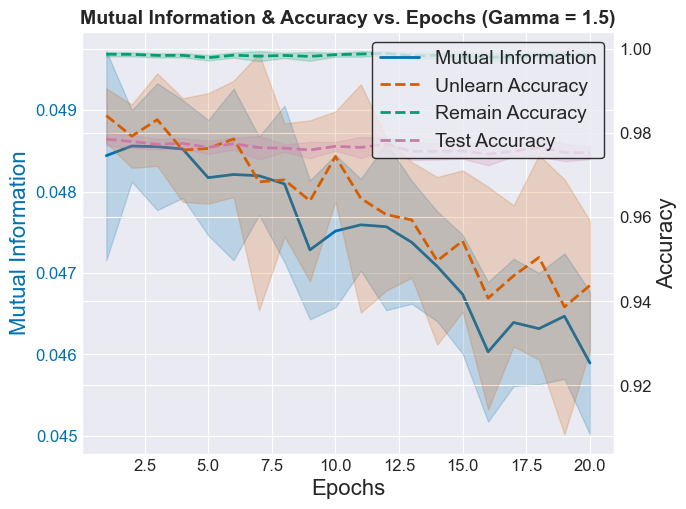

In [25]:
plot_icml_style(mi_history_list, acc_unlearn_history_list, acc_remain_history_list, acc_test_history_list, 20, filename="icml_plot.png")

In [10]:
mi_history_list = []
acc_unlearn_history_list = []
acc_remain_history_list = []
acc_test_history_list = []


for i in range(10):    
    model_unlearn = deepcopy(model_original)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_unlearn.parameters(), lr=0.001)

    ce_history, mi_history, acc_unlearn_history, acc_remain_history, acc_test_history, total_loss_history = train_unlearn_model(model_unlearn, train_unlearn_loader, train_remain_loader, criterion, optimizer, gamma=3.5, epochs=5)
    #evaluate_model(model_unlearn, train_remain_loader)
    #evaluate_model(model_unlearn, train_unlearn_loader)
    #evaluate_model(model_unlearn, test_loader)
    mi_history_list.append(mi_history)
    acc_unlearn_history_list.append(acc_unlearn_history)
    acc_remain_history_list.append(acc_remain_history)
    acc_test_history_list.append(acc_test_history)

Accuracy: 94.98%
Accuracy: 99.85%
Accuracy: 97.67%
Epoch 1/5 | CE: 0.0204, MI: 0.0468, Total Loss: 0.1842
Accuracy: 98.39%
Accuracy: 99.87%
Accuracy: 97.86%
Epoch 2/5 | CE: 0.0146, MI: 0.0476, Total Loss: 0.1810
Accuracy: 80.64%
Accuracy: 99.56%
Accuracy: 96.16%
Epoch 3/5 | CE: 0.0229, MI: 0.0446, Total Loss: 0.1790
Accuracy: 92.02%
Accuracy: 99.75%
Accuracy: 97.24%
Epoch 4/5 | CE: 0.0247, MI: 0.0421, Total Loss: 0.1721
Accuracy: 90.74%
Accuracy: 99.79%
Accuracy: 97.07%
Epoch 5/5 | CE: 0.0189, MI: 0.0441, Total Loss: 0.1732
Accuracy: 95.93%
Accuracy: 99.79%
Accuracy: 97.69%
Epoch 1/5 | CE: 0.0126, MI: 0.0487, Total Loss: 0.1830
Accuracy: 84.49%
Accuracy: 99.49%
Accuracy: 96.31%
Epoch 2/5 | CE: 0.0113, MI: 0.0478, Total Loss: 0.1785
Accuracy: 86.23%
Accuracy: 99.58%
Accuracy: 96.78%
Epoch 3/5 | CE: 0.0168, MI: 0.0461, Total Loss: 0.1781
Accuracy: 98.28%
Accuracy: 99.85%
Accuracy: 97.64%
Epoch 4/5 | CE: 0.0185, MI: 0.0461, Total Loss: 0.1798
Accuracy: 91.39%
Accuracy: 99.79%
Accuracy: 97

<Figure size 700x500 with 0 Axes>

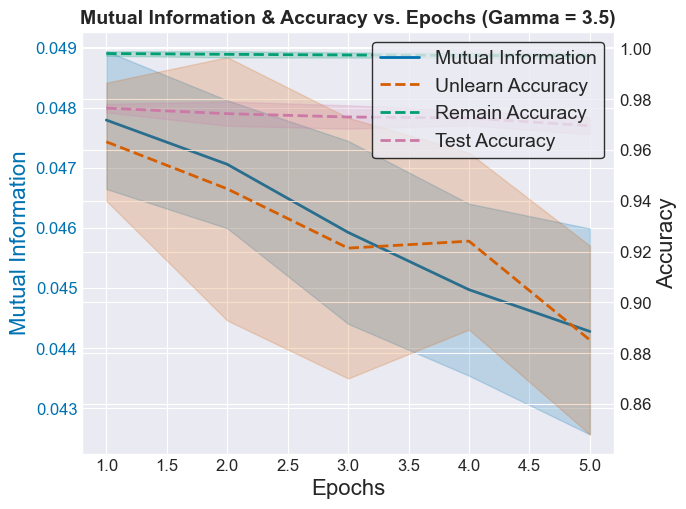

In [14]:
plot_icml_style(mi_history_list, acc_unlearn_history_list, acc_remain_history_list, acc_test_history_list, 5, filename="icml_plot.png")

In [15]:
mi_history_list = []
acc_unlearn_history_list = []
acc_remain_history_list = []
acc_test_history_list = []


for i in range(10):    
    model_unlearn = deepcopy(model_original)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_unlearn.parameters(), lr=0.001)

    ce_history, mi_history, acc_unlearn_history, acc_remain_history, acc_test_history, total_loss_history = train_unlearn_model(model_unlearn, train_unlearn_loader, train_remain_loader, criterion, optimizer, gamma=3.5, epochs=20)
    #evaluate_model(model_unlearn, train_remain_loader)
    #evaluate_model(model_unlearn, train_unlearn_loader)
    #evaluate_model(model_unlearn, test_loader)
    mi_history_list.append(mi_history)
    acc_unlearn_history_list.append(acc_unlearn_history)
    acc_remain_history_list.append(acc_remain_history)
    acc_test_history_list.append(acc_test_history)

Accuracy: 99.30%
Accuracy: 99.84%
Accuracy: 97.66%
Epoch 1/20 | CE: 0.0121, MI: 0.0479, Total Loss: 0.1797
Accuracy: 94.58%
Accuracy: 99.84%
Accuracy: 97.43%
Epoch 2/20 | CE: 0.0110, MI: 0.0498, Total Loss: 0.1852
Accuracy: 96.72%
Accuracy: 99.86%
Accuracy: 97.72%
Epoch 3/20 | CE: 0.0084, MI: 0.0472, Total Loss: 0.1735
Accuracy: 95.30%
Accuracy: 99.84%
Accuracy: 97.70%
Epoch 4/20 | CE: 0.0131, MI: 0.0461, Total Loss: 0.1744
Accuracy: 77.40%
Accuracy: 99.42%
Accuracy: 96.16%
Epoch 5/20 | CE: 0.0156, MI: 0.0451, Total Loss: 0.1735
Accuracy: 73.16%
Accuracy: 99.33%
Accuracy: 95.54%
Epoch 6/20 | CE: 0.0186, MI: 0.0415, Total Loss: 0.1639
Accuracy: 90.69%
Accuracy: 99.79%
Accuracy: 97.15%
Epoch 7/20 | CE: 0.0186, MI: 0.0411, Total Loss: 0.1626
Accuracy: 76.92%
Accuracy: 99.43%
Accuracy: 95.80%
Epoch 8/20 | CE: 0.0252, MI: 0.0371, Total Loss: 0.1552
Accuracy: 63.07%
Accuracy: 99.16%
Accuracy: 94.60%
Epoch 9/20 | CE: 0.0320, MI: 0.0358, Total Loss: 0.1573
Accuracy: 60.22%
Accuracy: 99.19%
Acc

<Figure size 700x500 with 0 Axes>

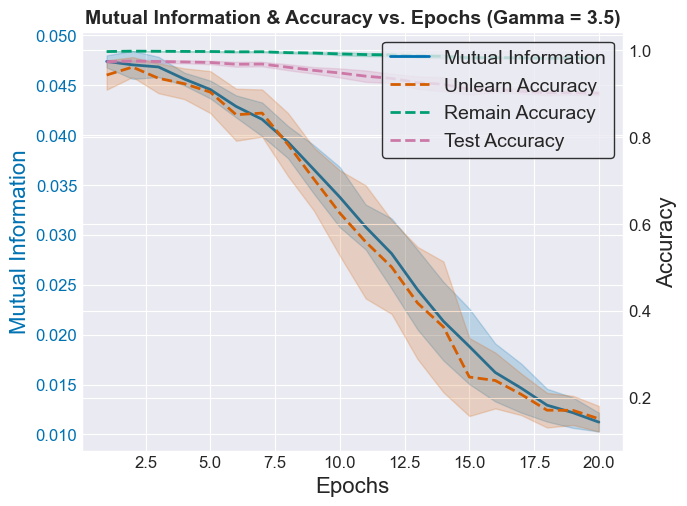

In [16]:
plot_icml_style(mi_history_list, acc_unlearn_history_list, acc_remain_history_list, acc_test_history_list, 20, filename="icml_plot.png")

In [17]:
mi_history_list = []
acc_unlearn_history_list = []
acc_remain_history_list = []
acc_test_history_list = []


for i in range(10):    
    model_unlearn = deepcopy(model_original)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_unlearn.parameters(), lr=0.001)

    ce_history, mi_history, acc_unlearn_history, acc_remain_history, acc_test_history, total_loss_history = train_unlearn_model(model_unlearn, train_unlearn_loader, train_remain_loader, criterion, optimizer, gamma=5, epochs=2)
    #evaluate_model(model_unlearn, train_remain_loader)
    #evaluate_model(model_unlearn, train_unlearn_loader)
    #evaluate_model(model_unlearn, test_loader)
    mi_history_list.append(mi_history)
    acc_unlearn_history_list.append(acc_unlearn_history)
    acc_remain_history_list.append(acc_remain_history)
    acc_test_history_list.append(acc_test_history)

Accuracy: 84.17%
Accuracy: 99.47%
Accuracy: 96.73%
Epoch 1/2 | CE: 0.0182, MI: 0.0463, Total Loss: 0.2499
Accuracy: 91.84%
Accuracy: 99.74%
Accuracy: 97.23%
Epoch 2/2 | CE: 0.0346, MI: 0.0438, Total Loss: 0.2537
Accuracy: 96.39%
Accuracy: 99.81%
Accuracy: 97.78%
Epoch 1/2 | CE: 0.0226, MI: 0.0477, Total Loss: 0.2609
Accuracy: 94.02%
Accuracy: 99.82%
Accuracy: 97.68%
Epoch 2/2 | CE: 0.0134, MI: 0.0475, Total Loss: 0.2509
Accuracy: 97.22%
Accuracy: 99.82%
Accuracy: 97.66%
Epoch 1/2 | CE: 0.0253, MI: 0.0469, Total Loss: 0.2597
Accuracy: 77.90%
Accuracy: 99.35%
Accuracy: 95.79%
Epoch 2/2 | CE: 0.0231, MI: 0.0452, Total Loss: 0.2492
Accuracy: 93.91%
Accuracy: 99.75%
Accuracy: 97.40%
Epoch 1/2 | CE: 0.0097, MI: 0.0491, Total Loss: 0.2551
Accuracy: 91.65%
Accuracy: 99.69%
Accuracy: 97.16%
Epoch 2/2 | CE: 0.0330, MI: 0.0428, Total Loss: 0.2469
Accuracy: 99.74%
Accuracy: 99.91%
Accuracy: 97.83%
Epoch 1/2 | CE: 0.0088, MI: 0.0491, Total Loss: 0.2543
Accuracy: 94.95%
Accuracy: 99.69%
Accuracy: 97

<Figure size 700x500 with 0 Axes>

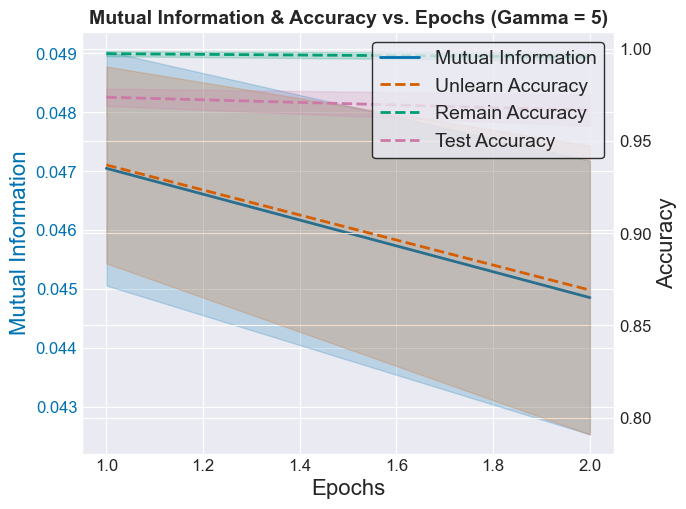

In [20]:
plot_icml_style(mi_history_list, acc_unlearn_history_list, acc_remain_history_list, acc_test_history_list, 2, filename="icml_plot.png")